In [4]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#Ensure Python can find the Code directory
sys.path.append(os.path.abspath(".."))

import utils

In [5]:
#Use functions and packages
df = utils.load_data()
df.head()

,activity_year,census_tract,derived_race,action_taken,loan_amount,property_value,income,interest_rate,tract_minority_population_percent,tract_to_msa_income_percentage,denial_reason-1,covenant_count,was_approved,covenant_density,county
0,2023,2.703706e+10,Race Not Available,6,185000.0,195000,NaN,6.125,40.37,73.48,10,0.0,False,NaN,Hennepin
1,2023,2.714103e+10,Race Not Available,6,375000.0,385000,NaN,6.625,10.64,121.26,10,0.0,False,NaN,Hennepin
2,2023,2.702395e+10,Race Not Available,6,105000.0,105000,NaN,6.125,8.92,90.13,10,0.0,False,NaN,Hennepin
3,2023,2.717110e+10,Race Not Available,6,285000.0,285000,NaN,6.75,13.27,104.37,10,0.0,False,NaN,Hennepin
4,2023,2.715948e+10,Race Not Available,6,175000.0,175000,NaN,6.875,5.87,82.22,10,0.0,False,NaN,Hennepin


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100931 entries, 0 to 100930
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   activity_year                      100931 non-null  int64  
 1   census_tract                       99915 non-null   float64
 2   derived_race                       100931 non-null  object 
 3   action_taken                       100931 non-null  int64  
 4   loan_amount                        100931 non-null  float64
 5   property_value                     83491 non-null   float64
 6   income                             88200 non-null   float64
 7   interest_rate                      78125 non-null   float64
 8   tract_minority_population_percent  100931 non-null  float64
 9   tract_to_msa_income_percentage     100931 non-null  float64
 10  denial_reason-1                    100931 non-null  int64  
 11  covenant_count                     1009

### Explore missing values

In [15]:
#For each column, show the number of missing values for each value of census_tract as a table
missing = df.groupby('census_tract').apply(lambda x: x.isnull().sum(), include_groups = False)
missing.head()

,activity_year,derived_race,action_taken,loan_amount,property_value,income,interest_rate,tract_minority_population_percent,tract_to_msa_income_percentage,denial_reason-1,covenant_count,was_approved,covenant_density
census_tract,,,,,,,,,,,,,
2.700177e+10,0,0,0,0,8,8,11,0,0,0,0,0,69
2.700177e+10,0,0,0,0,5,2,7,0,0,0,0,0,39
2.700177e+10,0,0,0,0,7,9,8,0,0,0,0,0,55
2.700177e+10,0,0,0,0,10,6,17,0,0,0,0,0,48
2.700177e+10,0,0,0,0,10,4,16,0,0,0,0,0,51


In [16]:
#Fill the property_value, income, and interest_rate columns with census_tract means
df['property_value'] = df['property_value'].fillna(df.groupby('census_tract')['property_value'].transform('mean'))
df['income'] = df['income'].fillna(df.groupby('census_tract')['income'].transform('mean'))
df['interest_rate'] = df['interest_rate'].fillna(df.groupby('census_tract')['interest_rate'].transform('mean'))

### Data Preparation for Classification

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline

In [18]:
#Create dummy variables for the categorical columns
categorical_features = ['derived_race', 'action_taken', 'denial_reason-1']
df_clean = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype='int64')

In [19]:
#Drop additional columns
df_clean.drop(columns=['covenant_density', 'census_tract','activity_year', 'tract_minority_population_percent', 'tract_to_msa_income_percentage', 'covenant_count'], inplace=True)

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100931 entries, 0 to 100930
Data columns (total 30 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   loan_amount                                             100931 non-null  float64
 1   property_value                                          100487 non-null  float64
 2   income                                                  100847 non-null  float64
 3   interest_rate                                           100177 non-null  float64
 4   was_approved                                            100931 non-null  bool   
 5   derived_race_American Indian or Alaska Native           100931 non-null  int64  
 6   derived_race_Asian                                      100931 non-null  int64  
 7   derived_race_Black or African American                  100931 non-null  int64  
 8   derived_race_Free Form T

In [21]:
#Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_clean_imputed = imputer.fit_transform(df_clean)
df_clean_imputed = pd.DataFrame(df_clean_imputed, columns=df_clean.columns)

In [22]:
#Split the data into features and target
X = df_clean_imputed.drop('was_approved', axis=1)
y = df_clean_imputed['was_approved']

In [23]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Predictive Modeling - Based on Hennepin County dataset

#### Logistic Regression

In [24]:
#Initialize and fit the Logistic Regression model
lr = LogisticRegression(solver='liblinear', max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [25]:
#Evaluate the model accuracy on the training and test sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

#Display the confusion matrix for the training set
print('Confusion Matrix - Training Set')
print(confusion_matrix(y_train_pred, y_train))
print('Confusion Matrix - Test Set')
print(confusion_matrix(y_test_pred, y_test))

Train accuracy: 0.664
Test accuracy: 0.666
Confusion Matrix - Training Set
[[    2     2]
 [23716 46931]]
Confusion Matrix - Test Set
[[    0     0]
 [10128 20152]]


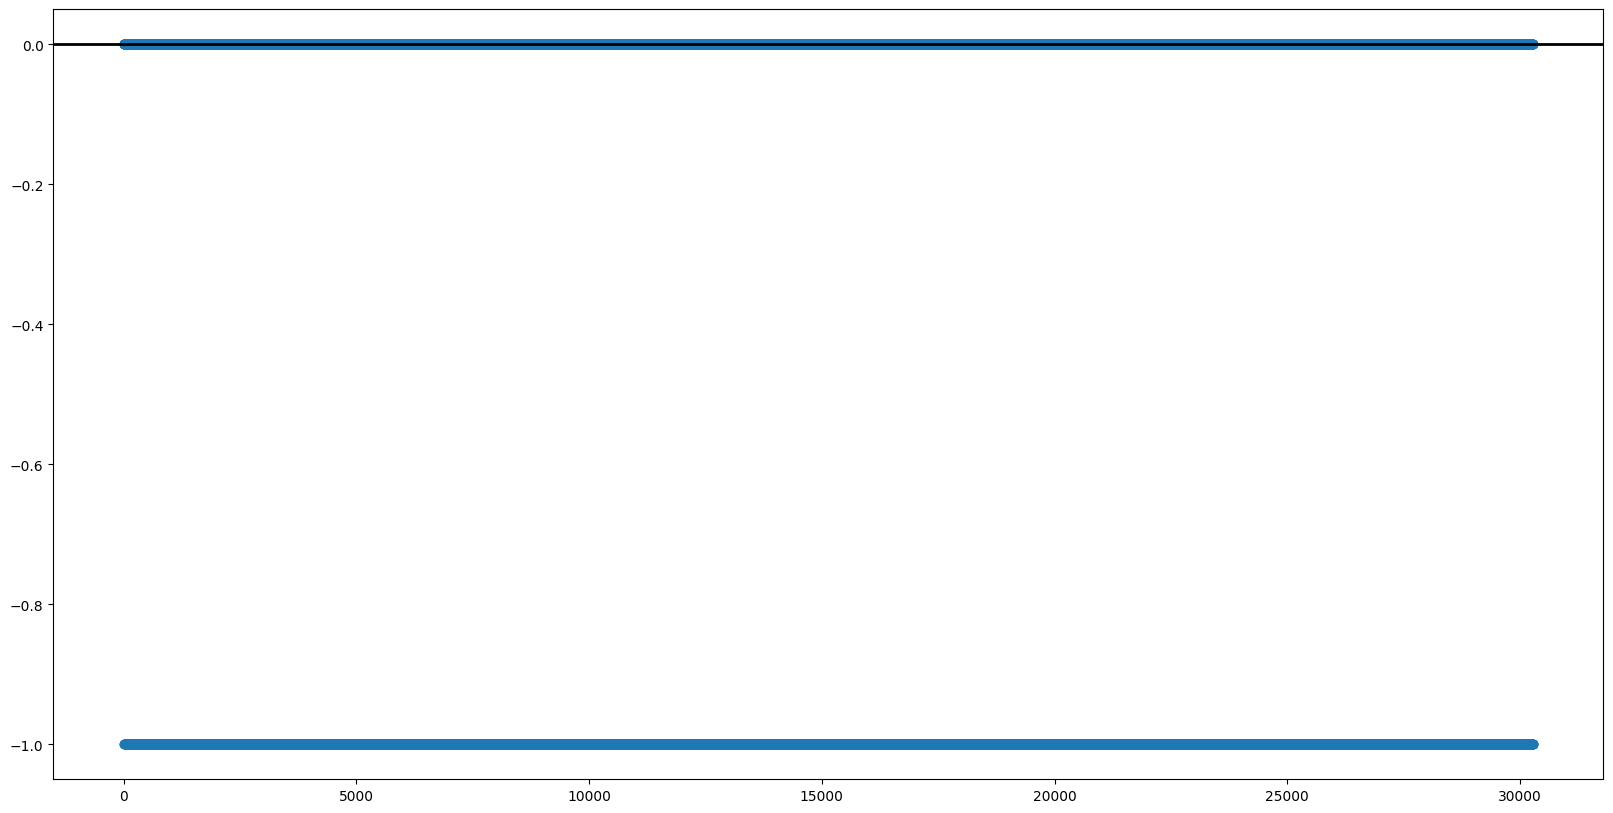

In [26]:
#Plot the residuals
y_pred_lr = lr.predict(X_test).astype(int)
plt.figure(figsize=(20, 10))
plt.scatter(range(len(y_pred_lr)), y_test - y_pred_lr)
plt.axhline(0, color='black', lw=2)

#### KNN Classification

In [27]:
#Create the cross-validation method
cv_method = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
#Define the search grid and number of neighbors
search_grid = dict()
search_grid['n_neighbors'] = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
#Execute the grid search
best_score = 0
#Minimum improvement threshold
tolerance = 0.001
#Number of iterations to wait before stopping  
patience = 3  
wait = 0
best_n = None
best_model = None
for n in search_grid['n_neighbors']:
    model = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(model, X_train, y_train, cv=cv_method, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)

    if mean_score > best_score + tolerance:
        best_score = mean_score
        best_n = n
        wait = 0  # Reset patience counter
    else:
        wait += 1

    if wait >= patience:
        print(f"Early stopping triggered. Best n_neighbors: {best_n} with accuracy {best_score:.4f}")
        break

print(f"Final best n_neighbors: {best_n} with accuracy {best_score:.4f}")


Early stopping triggered. Best n_neighbors: 3 with accuracy 0.7242
Final best n_neighbors: 3 with accuracy 0.7242


In [28]:
#Run the KNN model with the best parameters
k = best_n
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [29]:
#Evaluate the model accuracy on the training and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

#Display the confusion matrix for the training set
print('Confusion Matrix - Training Set')
print(confusion_matrix(y_train_pred, y_train))
print('Confusion Matrix - Test Set')
print(confusion_matrix(y_test_pred, y_test))


Train accuracy: 0.855
Test accuracy: 0.728
Confusion Matrix - Training Set
[[16208  2726]
 [ 7510 44207]]
Confusion Matrix - Test Set
[[ 4602  2703]
 [ 5526 17449]]


#### Support Vector Classification

In [30]:
SVCrbf = make_pipeline(StandardScaler(), SVC(kernel='rbf',max_iter=-1))
SVCrbf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [31]:
#Evaluate the model accuracy on the training and test sets
y_train_pred = SVCrbf.predict(X_train)
y_test_pred = SVCrbf.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

#Display the confusion matrix for the training set
print('Confusion Matrix - Training Set')
print(confusion_matrix(y_train_pred, y_train))
print('Confusion Matrix - Test Set')
print(confusion_matrix(y_test_pred, y_test))

Train accuracy: 1.000
Test accuracy: 1.000
Confusion Matrix - Training Set
[[23717     0]
 [    1 46933]]
Confusion Matrix - Test Set
[[10123     3]
 [    5 20149]]


#### Decision Tree Classification

In [32]:
#Initialize and fit the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
#Evaluate the model accuracy on the training and test sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

#Display the confusion matrix for the training set
print('Confusion Matrix - Training Set')
print(confusion_matrix(y_train_pred, y_train))
print('Confusion Matrix - Test Set')
print(confusion_matrix(y_test_pred, y_test))

Train accuracy: 1.000
Test accuracy: 1.000
Confusion Matrix - Training Set
[[23718     0]
 [    0 46933]]
Confusion Matrix - Test Set
[[10128     0]
 [    0 20152]]


#### Analysis and Comparison of Model Performance

### Predictive Modeling - Applying the models to Ramsey County dataset

### Limitations